# 代码来源：https://blog.csdn.net/qq_42818403/article/details/122907583

In [1]:
import numpy as np
import sys
print(sys.executable)
from mpl_toolkits import mplot3d


import deepxde as dde

# 用于绘图
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

print(sys.executable)

D:\anaconda\python.exe


Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.


D:\anaconda\python.exe


In [2]:
#周期性边界条件
x_lower = -5
x_upper = 5
t_lower = 0
t_upper = np.pi/2

# 创建 2D 域（用于绘图和输入）
x = np.linspace(x_lower, x_upper, 512)
t = np.linspace(t_lower, t_upper, 402)
X, T = np.meshgrid(x, t)

# 整个域变平
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# 空间和时间域/几何（对于 deepxde 模型）
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)


In [3]:
# 损失的“物理信息”部分


def pde(x,y):
    """
    INPUTS:
        x: x[:,0] 是 x 坐标
           x[:,1] 是 t 坐标
        y: 网络输出，在这种情况下:
            y[:,0] 是 u(x,t) 实部
            y[:,1] 是 v(x,t) 虚部
    OUTPUT:
        标准形式的 pde，即必须为零的东西
    """
    
    
    u1 = y[:, 0:1]
    v1 = y[:, 1:2]
    u2 = y[:, 2:3]
    v2 = y[:, 3:4]
    

    # 在'jacobian'中，i 是输出分量，j 是输入分量
    u1_t = dde.grad.jacobian(y, x, i=0, j=1)
    v1_t = dde.grad.jacobian(y, x, i=1, j=1)
    u2_t = dde.grad.jacobian(y, x, i=2, j=1)
    v2_t = dde.grad.jacobian(y, x, i=3, j=1)

    u1_x = dde.grad.jacobian(y, x, i=0, j=0)
    v1_x = dde.grad.jacobian(y, x, i=1, j=0)
    u2_x = dde.grad.jacobian(y, x, i=2, j=0)
    v2_x = dde.grad.jacobian(y, x, i=3, j=0)

    # 在“hessian”中，i 和 j 都是输入分量。 （Hessian 原则上可以是 d^2y/dxdt、d^2y/d^2x 等）
    # 输出组件由“组件”选择
    u1_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    u2_xx = dde.grad.hessian(y, x, component=2, i=0, j=0)
    v2_xx = dde.grad.hessian(y, x, component=3, i=0, j=0)

    #f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    #f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u
    
    f_u1 = u1_t + v1_xx + 2*(v1 ** 2 + u1 ** 2 + 2*(v2 ** 2 + u2 ** 2)) * v1 - 2*v1*(v2 ** 2 - u2 ** 2) - 4*v2*u1*u2
    f_v1 = v1_t - u1_xx - 2*(v1 ** 2 + u1 ** 2 + 2*(v2 ** 2 + u2 ** 2)) * u1 - 2*u1*(v2 ** 2 - u2 ** 2) + 4*v1*v2*u2
    
    f_u2 = u2_t + v2_xx + 2*(v2 ** 2 + u2 ** 2 + 2*(v1 ** 2 + u1 ** 2)) * v2 - 2*v2*(v1 ** 2 - u1 ** 2) - 4*v1*u2*u1
    f_v2 = v2_t - u2_xx - 2*(v2 ** 2 + u2 ** 2 + 2*(v1 ** 2 + u1 ** 2)) * u2 - 2*u2*(v1 ** 2 - u1 ** 2) + 4*v2*v1*u1

    return [f_u1, f_v1,f_u2,f_v2]


In [4]:
# 边界条件和初始条件

# 周期性边界条件
bc_u1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)
bc_u2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=2
)
bc_u2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=2
)
bc_v2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=3
)
bc_v2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=3
)

# 初始条件
def init_cond_u1(x):
    "2 sech(x)"
    return 2 / np.cosh(x[:, 0:1])
def init_cond_u2(x):
    "2 tanh(x)"
    return 2* np.sinh(x[:, 0:1]) /np.cosh(x[:, 0:1])

def init_cond_v(x):
    return 0


ic_u1 = dde.IC(geomtime, init_cond_u1, lambda _, on_initial: on_initial, component=0)
ic_v1 = dde.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)
ic_u2 = dde.IC(geomtime, init_cond_u2, lambda _, on_initial: on_initial, component=2)
ic_v2 = dde.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=3)


In [5]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u1_0, bc_u1_1, bc_v1_0, bc_v1_1,bc_u2_0, bc_u2_1, bc_v2_0, bc_v2_1, ic_u1, ic_v1,ic_u2, ic_v2],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

allow_unused=True
# 网络架构
net = dde.maps.FNN([2] + [100] * 4 + [4], "sin", "Glorot normal")

model = dde.Model(data, net)


Adam 优化

In [6]:

# 强烈建议使用 GPU 加速系统.

model.compile("adam", lr=1e-3, loss="MSE")
model.train(epochs=10000, display_every=1000)


Compiling model...
Building feed-forward neural network...
'build' took 0.070141 s



C:\Users\86183\AppData\Roaming\Python\Python39\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.500873 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [5.02e-02, 6.49e-01, 5.52e-01, 5.76e-01, 1.21e+00, 2.73e-04, 1.05e-03, 1.04e-05, 2.16e+00, 7.81e-04, 4.47e-01, 3.97e-03, 9.48e-01, 1.31e-03, 5.23e+00, 5.39e-02]    [5.02e-02, 6.49e-01, 5.52e-01, 5.76e-01, 1.21e+00, 2.73e-04, 1.05e-03, 1.04e-05, 2.16e+00, 7.81e-04, 4.47e-01, 3.97e-03, 9.48e-01, 1.31e-03, 5.23e+00, 5.39e-02]    []  
1000      [4.97e-02, 4.47e-02, 1.25e-01, 1.08e-01, 1.19e-04, 2.40e-04, 8.92e-05, 3.06e-04, 2.74e-02, 5.07e-04, 9.46e-03, 3.16e-04, 4.75e-02, 3.07e-03, 5.08e-01, 2.62e-03]    [4.97e-02, 4.47e-02, 1.25e-01, 1.08e-01, 1.19e-04, 2.40e-04, 

(<deepxde.model.LossHistory at 0x136176847c0>,
 <deepxde.model.TrainState at 0x13617672730>)

L-BFGS 优化

Compiling model...
'compile' took 1.889478 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
10000     [1.76e-02, 3.16e-02, 3.63e-02, 3.36e-02, 1.19e-04, 7.24e-04, 1.01e-04, 6.82e-04, 1.73e-02, 1.53e-04, 9.16e-03, 2.22e-04, 4.66e-02, 4.03e-02, 1.47e-01, 1.20e-02]    [1.76e-02, 3.16e-02, 3.63e-02, 3.36e-02, 1.19e-04, 7.24e-04, 1.01e-04, 6.82e-04, 1.73e-02, 1.53e-04, 9.16e-03, 2.22e-04, 4.66e-02, 4.03e-02, 1.47e-01, 1.20e-02]    []  
11000     [1.68e-02, 2.69e-02, 2.40e-02, 2.06e-02, 5.26e-05, 5.04e-04, 8.83e-05, 6.13e-04, 9.23e-03, 7.55e-05, 7.83e-03, 2.98e-04, 4.29e-02, 5.43e-02, 5.98e-02, 1.58e-02]                                                                        

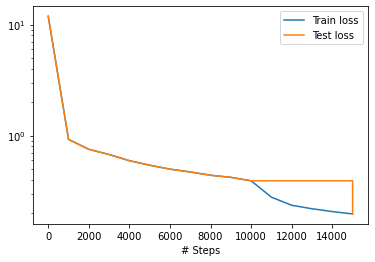

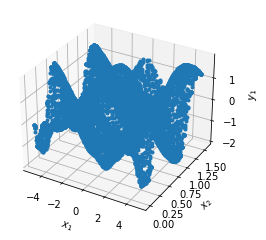

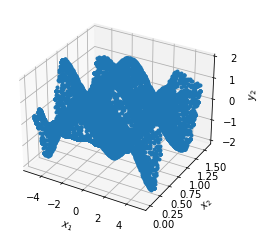

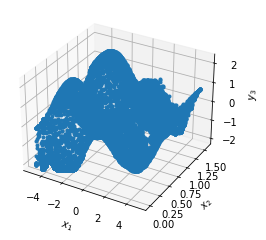

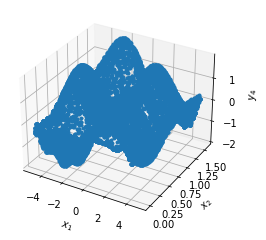

In [7]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=5000,
    maxfun=5000,
    maxls=50,
)
model.compile("L-BFGS")
#model.train()

losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

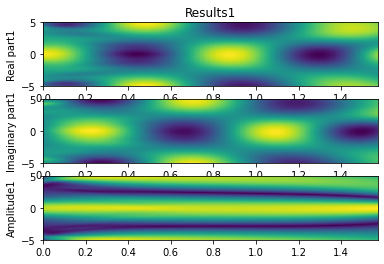

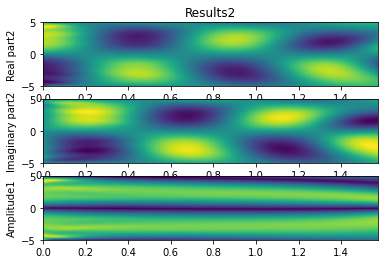

In [8]:
# 做预测
prediction = model.predict(X_star, operator=None)

u1 = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v1 = griddata(X_star, prediction[:, 1], (X, T), method="cubic")
u2 = griddata(X_star, prediction[:, 2], (X, T), method="cubic")
v2 = griddata(X_star, prediction[:, 3], (X, T), method="cubic")


h1 = np.sqrt(u1 ** 2 + v1 ** 2)
h2=np.sqrt(u2**2+v2**2)



# 绘制预测
fig, ax = plt.subplots(3)

ax[0].set_title("Results1")
ax[0].set_ylabel("Real part1")
ax[0].imshow(
    u1.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part1")
ax[1].imshow(
    v1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude1")
ax[2].imshow(
    h1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

fig, bx = plt.subplots(3)
bx[0].set_title("Results2")
bx[0].set_ylabel("Real part2")
bx[0].imshow(
    u2.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
bx[1].set_ylabel("Imaginary part2")
bx[1].imshow(
    v2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
bx[2].set_ylabel("Amplitude1")
bx[2].imshow(
    h2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
plt.show()


[ 77483  47542  30654 ... 705746 698993 692258]


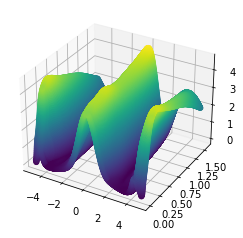

In [9]:
ax = plt.axes(projection='3d')


b=prediction[:,0]**2+prediction[:,1]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
# Data for a three-dimensional line
ax.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:])



[366851 334554 306925 ...  45507  47164  48852]
(402, 512)
(402, 512)
(205824, 2)
(205824, 4)


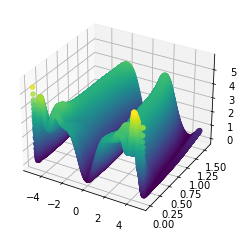

In [10]:
bx = plt.axes(projection='3d')
b=prediction[:,2]**2+prediction[:,3]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
bx.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:])

print(X.shape)
print(T.shape)
print(X_star.shape)
print(prediction.shape)

In [11]:
X = geomtime.random_points(100000)
err = 1
while err > 0.005:
    f = model.predict(X, operator=pde)
    print(np.array(f).shape)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))
    err_eq=err_eq.flatten()
    print(err_eq.shape)
    x_id = np.argmax(err_eq)
    print(x_id)
    print("Adding new point:", X[int(x_id/4)], "\n")
    data.add_anchors(X[int(x_id/4)])
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile("adam", lr=1e-3)
    model.train(iterations=10000, disregard_previous_best=True, callbacks=[early_stopping])
    model.compile("L-BFGS")
    losshistory, train_state = model.train(callbacks=[early_stopping])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X, y_true = gen_testdata(callbacks=[early_stopping])
y_pred = model.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

(4, 100000, 1)
Mean residual: 6.218e-02
(400000,)
385151
Adding new point: [1.6610746 0.3300336] 

Compiling model...
'compile' took 3.101000 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
15001     [1.19e-02, 1.70e-02, 1.17e-02, 7.76e-03, 1.69e-04, 6.54e-04, 2.21e-04, 2.91e-04, 2.03e-03, 4.07e-05, 6.34e-03, 1.42e-05, 3.73e-02, 6.08e-02, 2.55e-02, 1.63e-02]    [1.19e-02, 1.70e-02, 1.17e-02, 7.76e-03, 1.69e-04, 6.54e-04, 2.21e-04, 2.91e-04, 2.03e-03, 4.07e-05, 6.34e-03, 1.42e-05, 3.73e-02, 6.08e-02, 2.55e-02, 1.63e-02]    []  
16000     [4.07e-02, 5.50e-02, 5.90e-02, 5.62e-02, 3.74e-04, 1.12e-03, 8.10e-04, 3.21e-03, 2.35e-03, 3.47e-04, 1.13e-02, 4.14e-04, 4.14e-02, 6.

28000     [1.16e-02, 1.67e-02, 9.77e-03, 6.29e-03, 2.41e-04, 3.34e-04, 2.37e-04, 2.13e-04, 3.09e-03, 1.65e-05, 4.53e-03, 2.18e-05, 3.19e-02, 5.61e-02, 1.57e-02, 1.05e-02]                                                                                                                                                                            
29000     [1.17e-02, 1.67e-02, 8.68e-03, 5.63e-03, 1.93e-04, 3.05e-04, 2.77e-04, 1.67e-04, 2.97e-03, 1.51e-05, 3.73e-03, 1.59e-05, 3.07e-02, 5.68e-02, 1.26e-02, 9.56e-03]                                                                                                                                                                            
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  Objective function value: 0.159949
  Number of iterations: 4788
  Number of functions evaluations: 5001
29005     [1.17e-02, 1.67e-02, 8.65e-03, 5.64e-03, 2.00e-04, 2.96e-04, 2.70e-04, 1.76e-04, 2.99e-0

38008     [3.36e-02, 3.78e-02, 4.31e-02, 3.59e-02, 7.60e-04, 1.23e-03, 6.88e-04, 9.12e-04, 5.24e-03, 1.76e-03, 1.03e-02, 8.71e-04, 4.55e-02, 7.89e-02, 6.33e-02, 1.06e-02]    [3.36e-02, 3.78e-02, 4.31e-02, 3.59e-02, 7.60e-04, 1.23e-03, 6.88e-04, 9.12e-04, 5.24e-03, 1.76e-03, 1.03e-02, 8.71e-04, 4.55e-02, 7.89e-02, 6.33e-02, 1.06e-02]    []  
39000     [1.29e-02, 1.94e-02, 1.33e-02, 1.23e-02, 1.23e-04, 7.51e-04, 2.37e-04, 3.03e-04, 2.66e-03, 5.95e-05, 6.72e-03, 1.86e-04, 3.80e-02, 5.91e-02, 3.24e-02, 1.08e-02]                                                                                                                                                                            
40000     [1.18e-02, 1.68e-02, 9.47e-03, 8.45e-03, 3.02e-04, 3.72e-04, 2.46e-04, 2.01e-04, 3.16e-03, 7.38e-05, 5.78e-03, 4.38e-05, 3.47e-02, 5.92e-02, 2.07e-02, 9.98e-03]                                                                                                                                                

51000     [1.66e-01, 1.53e-01, 1.43e-01, 1.62e-01, 2.13e-03, 2.79e-03, 1.74e-03, 2.58e-03, 3.57e-03, 1.15e-03, 1.10e-02, 7.38e-04, 3.39e-02, 5.11e-02, 5.54e-02, 1.12e-02]    [1.66e-01, 1.53e-01, 1.43e-01, 1.62e-01, 2.13e-03, 2.79e-03, 1.74e-03, 2.58e-03, 3.57e-03, 1.15e-03, 1.10e-02, 7.38e-04, 3.39e-02, 5.11e-02, 5.54e-02, 1.12e-02]    []  
52000     [8.15e-02, 8.16e-02, 8.76e-02, 8.83e-02, 8.74e-04, 6.42e-04, 1.05e-03, 5.70e-04, 2.12e-03, 4.33e-04, 6.28e-03, 8.24e-04, 3.14e-02, 3.71e-02, 9.93e-02, 8.35e-03]    [8.15e-02, 8.16e-02, 8.76e-02, 8.83e-02, 8.74e-04, 6.42e-04, 1.05e-03, 5.70e-04, 2.12e-03, 4.32e-04, 6.28e-03, 8.24e-04, 3.14e-02, 3.71e-02, 9.93e-02, 8.35e-03]    []  
Epoch 52012: early stopping

Best model at step 50011:
  train loss: 1.28e-01
  test loss: 1.28e-01
  test metric: []

'train' took 53.812021 s

Compiling model...
'compile' took 2.343194 s

Training model...

Step      Train loss                                                                                    

64015     [1.01e-02, 9.73e-03, 6.40e-03, 4.31e-03, 3.49e-04, 1.43e-04, 4.48e-04, 5.94e-05, 2.83e-04, 4.28e-05, 7.25e-04, 1.20e-04, 1.34e-02, 4.21e-02, 3.25e-03, 4.58e-03]    [1.01e-02, 9.74e-03, 6.40e-03, 4.32e-03, 3.49e-04, 1.43e-04, 4.48e-04, 5.94e-05, 2.83e-04, 4.28e-05, 7.25e-04, 1.20e-04, 1.34e-02, 4.21e-02, 3.25e-03, 4.58e-03]    []  

Best model at step 64015:
  train loss: 9.61e-02
  test loss: 9.61e-02
  test metric: []

'train' took 161.835849 s

(4, 100000, 1)
Mean residual: 6.660e-02
(400000,)
182957
Adding new point: [-3.6229107  1.0930812] 

Compiling model...
'compile' took 2.899993 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
64015     [1.01e-02, 9.

76000     [9.71e-03, 8.70e-03, 8.11e-03, 5.87e-03, 2.89e-04, 5.61e-05, 5.02e-04, 5.47e-05, 2.69e-04, 8.46e-05, 5.86e-04, 5.34e-05, 8.47e-03, 3.32e-02, 6.06e-03, 3.66e-03]                                                                                                                                                                            
77000     [8.60e-03, 7.66e-03, 5.99e-03, 4.46e-03, 3.89e-04, 5.01e-05, 4.44e-04, 7.35e-05, 2.19e-04, 2.01e-05, 4.05e-04, 3.19e-05, 7.73e-03, 3.13e-02, 3.03e-03, 3.45e-03]                                                                                                                                                                            
78000     [7.92e-03, 7.27e-03, 4.85e-03, 3.81e-03, 2.87e-04, 4.37e-05, 5.06e-04, 4.71e-05, 1.67e-04, 2.68e-05, 2.43e-04, 4.48e-05, 6.76e-03, 2.90e-02, 1.64e-03, 3.24e-03]                                                                                                                                                

Compiling model...
'compile' took 2.691346 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
87022     [7.82e-02, 1.35e-01, 1.30e-01, 8.49e-02, 1.25e-03, 5.25e-04, 3.44e-04, 7.44e-04, 8.64e-04, 1.17e-03, 2.80e-03, 1.02e-03, 8.92e-02, 4.03e-02, 1.44e-01, 2.81e-02]    [7.81e-02, 1.34e-01, 1.30e-01, 8.48e-02, 1.25e-03, 5.25e-04, 3.44e-04, 7.44e-04, 8.64e-04, 1.17e-03, 2.80e-03, 1.02e-03, 8.92e-02, 4.03e-02, 1.44e-01, 2.81e-02]    []  
88000     [1.74e-02, 2.19e-02, 3.20e-02, 2.52e-02, 8.70e-04, 2.92e-04, 3.87e-04, 3.20e-04, 3.34e-04, 4.93e-04, 1.70e-03, 3.40e-04, 2.11e-02, 2.90e-02, 6.21e-02, 5.05e-03]                                                                        

99025     [4.77e-03, 4.76e-03, 2.72e-03, 2.49e-03, 1.70e-04, 1.03e-04, 3.11e-04, 7.23e-05, 1.14e-04, 1.37e-05, 1.04e-04, 2.01e-05, 5.06e-03, 2.05e-02, 1.38e-03, 2.74e-03]    [4.78e-03, 4.76e-03, 2.72e-03, 2.49e-03, 1.70e-04, 1.03e-04, 3.11e-04, 7.23e-05, 1.14e-04, 1.37e-05, 1.04e-04, 2.01e-05, 5.06e-03, 2.05e-02, 1.38e-03, 2.74e-03]    []  
100000    [1.78e-01, 2.27e-01, 2.12e-01, 1.65e-01, 2.71e-03, 2.85e-03, 1.54e-03, 2.39e-03, 1.98e-03, 1.23e-03, 3.44e-03, 2.32e-03, 1.83e-01, 4.54e-02, 8.99e-02, 7.94e-02]    [1.79e-01, 2.27e-01, 2.12e-01, 1.65e-01, 2.71e-03, 2.85e-03, 1.54e-03, 2.39e-03, 1.98e-03, 1.23e-03, 3.44e-03, 2.32e-03, 1.83e-01, 4.54e-02, 8.99e-02, 7.94e-02]    []  
101000    [1.31e-01, 1.53e-01, 1.15e-01, 1.17e-01, 1.06e-03, 1.16e-03, 1.12e-03, 7.44e-04, 1.14e-03, 7.12e-04, 1.82e-03, 2.31e-04, 1.19e-01, 3.45e-02, 9.61e-02, 4.97e-02]    [1.31e-01, 1.53e-01, 1.15e-01, 1.17e-01, 1.06e-03, 1.16e-03, 1.12e-03, 7.44e-04, 1.14e-03, 7.12e-04, 1.82e-03, 2.31e-04, 1.19e-01, 3.45e-02,

INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  Objective function value: 0.046650
  Number of iterations: 4635
  Number of functions evaluations: 5001
113029    [4.81e-03, 4.50e-03, 3.61e-03, 3.04e-03, 1.01e-04, 7.59e-05, 3.53e-04, 4.93e-05, 1.16e-04, 4.15e-05, 1.18e-04, 1.60e-05, 4.94e-03, 1.99e-02, 2.53e-03, 2.46e-03]    [4.81e-03, 4.51e-03, 3.61e-03, 3.04e-03, 1.01e-04, 7.59e-05, 3.53e-04, 4.93e-05, 1.16e-04, 4.15e-05, 1.18e-04, 1.60e-05, 4.94e-03, 1.99e-02, 2.53e-03, 2.46e-03]    []  

Best model at step 106027:
  train loss: 4.44e-02
  test loss: 4.44e-02
  test metric: []

'train' took 164.348191 s

(4, 100000, 1)
Mean residual: 1.060e-01
(400000,)
96441
Adding new point: [-2.7942994  1.3972421] 

Compiling model...
'compile' took 3.288075 s

Training model...

Step      Train loss                                                                                                                                         

124000    [9.50e-03, 1.20e-02, 1.51e-02, 1.15e-02, 5.33e-04, 1.03e-04, 1.83e-04, 6.06e-05, 4.44e-04, 1.83e-04, 5.44e-04, 2.04e-04, 9.25e-03, 2.38e-02, 2.95e-02, 9.63e-03]                                                                                                                                                                            
125000    [8.62e-03, 1.05e-02, 1.21e-02, 1.01e-02, 3.43e-04, 9.68e-05, 2.31e-04, 4.10e-05, 3.73e-04, 1.07e-04, 3.97e-04, 1.57e-04, 7.22e-03, 2.29e-02, 2.48e-02, 9.02e-03]                                                                                                                                                                            
126000    [7.93e-03, 8.69e-03, 1.01e-02, 9.02e-03, 3.48e-04, 4.66e-05, 1.11e-04, 5.90e-05, 3.81e-04, 8.98e-05, 3.60e-04, 1.01e-04, 6.27e-03, 2.19e-02, 2.17e-02, 8.21e-03]                                                                                                                                                

Epoch 136037: early stopping

Best model at step 134036:
  train loss: 7.60e-02
  test loss: 7.60e-02
  test metric: []

'train' took 60.166962 s

Compiling model...
'compile' took 3.329264 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
136037    [3.32e-02, 3.37e-02, 4.79e-02, 4.37e-02, 9.89e-04, 5.12e-04, 9.28e-04, 4.25e-04, 9.65e-04, 1.02e-03, 7.90e-04, 3.46e-03, 1.15e-02, 2.05e-02, 4.39e-02, 7.62e-03]    [3.32e-02, 3.37e-02, 4.80e-02, 4.37e-02, 9.89e-04, 5.12e-04, 9.28e-04, 4.25e-04, 9.65e-04, 1.02e-03, 7.90e-04, 3.46e-03, 1.15e-02, 2.05e-02, 4.39e-02, 7.62e-03]    []  
137000    [8.71e-03, 1.12e-02, 1.23e-02, 1.08e-02, 3.50e-04, 1.88e-04, 1.28e-04, 8.60e-05, 1.91

KeyboardInterrupt: 